In [143]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import models
import numpy as np
from collections import deque
import random
import copy
from torch.utils.data import Dataset, DataLoader, random_split
import pandas as pd
from PIL import Image
import torchvision.transforms as transforms
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
import glob
import os
import matplotlib.pyplot as plt
import math

# Dataset

In [144]:
spineData : str = "../data/spine"

In [145]:
normalPath : str = "../data/spine/Normal"
osteopenia : str = "../data/spine/Osteopenia"
Osteoporosis : str = "../data/spine/Osteoporosis"

In [146]:
df = pd.DataFrame(columns=["path", "category"])
df

,path,category


In [147]:
def list_images(folder_path):
    extensions = ('*.png', '*.jpg', '*.jpeg', '*.bmp', '*.gif', '*.tiff', '*.webp')

    image_paths = []
    for ext in extensions:
        image_paths.extend(glob.glob(os.path.join(folder_path, ext)))

    return [os.path.abspath(img) for img in image_paths]

In [148]:
def assignCategory(df : pd.DataFrame, images : list[str], category : str) -> pd.DataFrame:
  for image in images:
    new_row = pd.DataFrame([{"path": image, "category": category}])
    df = pd.concat([df, new_row], ignore_index=True)
  return df

In [149]:
df = assignCategory(df, list_images(normalPath), "Normal")
df = assignCategory(df, list_images(osteopenia), "Osteopenia")
df = assignCategory(df, list_images(Osteoporosis), "Osteoporosis")

In [150]:
class Xray(Dataset):
  def __init__(self, df : pd.DataFrame):
    self.df = df
    self.transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    #transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
    ])
    #{0 : normal, 1 : osteia, 2 : osteois}
  def __len__(self):
    return len(self.df)
  def __getitem__(self, idx):
    image_path = self.df.iloc[idx]["path"]
    label = self.df.iloc[idx]["category"]
    if label == "Normal":
      label = torch.tensor(0, dtype=torch.long)
    elif label == "Osteopenia":
      label = torch.tensor(1, dtype=torch.long)
    elif label == "Osteoporosis":
      label = torch.tensor(2, dtype=torch.long)
    else:
      raise ValueError("Invalid label")
    image = Image.open(image_path).convert("RGB")
    image = self.transforms(image)
    return image, label

In [151]:
xrays = Xray(df)

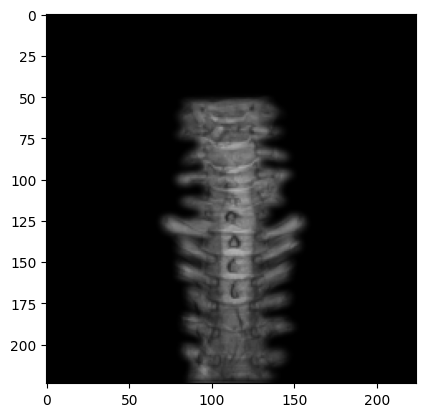

In [152]:
image = xrays[4][0]
image = image.permute(1, 2, 0).numpy()
plt.imshow(image)

In [162]:
train_size = int(0.8 * len(df))
test_size = len(df) - train_size
train_dataset, test_dataset = random_split(xrays, [train_size, test_size])

In [163]:
trainLoader = DataLoader(train_dataset, batch_size=16, shuffle=True, drop_last=True)
testLoader = DataLoader(test_dataset, batch_size=16, shuffle=False, drop_last=True)

In [182]:
evalLoader = DataLoader(xrays, batch_size=16, shuffle=False, drop_last=True)

In [164]:
len(xrays)

136

In [165]:
# Load the base model
def load_base_model():
    model = models.mobilenet_v2(pretrained=True)
    model.classifier[1] = nn.Linear(model.classifier[1].in_features, 3)
    model.load_state_dict(torch.load('../checkpoints/best_mobilenet_modelv2.pth'))
    return model

class DQN(nn.Module):
    def __init__(self, feature_size=1280, n_actions=3):  # Changed feature_size to match MobileNetV2
        super(DQN, self).__init__()
        self.fc1 = nn.Linear(feature_size, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, n_actions)
        
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        return self.fc3(x)

# Experience Replay Memory
class ReplayMemory:
    def __init__(self, capacity):
        self.memory = deque(maxlen=capacity)
        
    def push(self, state, action, reward, next_state):
        self.memory.append((state, action, reward, next_state))
        
    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)
    
    def __len__(self):
        return len(self.memory)

In [166]:
class RLClassifier:
    def __init__(self, base_model, device):
        self.base_model = base_model.to(device)
        self.device = device
        
        # Get feature size from base model's last conv layer
        self.feature_size = 1280  # MobileNetV2's feature size
        self.n_actions = 3
        
        # Initialize DQN networks
        self.policy_net = DQN(self.feature_size, self.n_actions).to(device)
        self.target_net = DQN(self.feature_size, self.n_actions).to(device)
        self.target_net.load_state_dict(self.policy_net.state_dict())
        
        self.optimizer = optim.Adam(self.policy_net.parameters())
        self.memory = ReplayMemory(10000)
        
        # Hyperparameters
        self.batch_size = 32
        self.gamma = 0.99
        self.eps_start = 0.9
        self.eps_end = 0.05
        self.eps_decay = 200
        self.target_update = 10
        self.steps_done = 0

        self.loss_ema = 0.0  # Exponential moving average of loss
        self.ema_alpha = 0.95  # EMA smoothing factor
        
    def get_features(self, x):
        # Remove classifier to get features
        self.base_model.eval()  # Set to eval mode
        with torch.no_grad():
            # Get features before the classifier
            features = self.base_model.features(x)
            # Global average pooling
            features = nn.functional.adaptive_avg_pool2d(features, (1, 1))
            features = features.view(features.size(0), -1)
        return features

    def select_action(self, state):
        sample = random.random()
        eps_threshold = self.eps_end + (self.eps_start - self.eps_end) * \
            math.exp(-1. * self.steps_done / self.eps_decay)
        self.steps_done += 1
        
        if sample > eps_threshold:
            with torch.no_grad():
                return self.policy_net(state).max(1)[1].view(1, 1)
        else:
            return torch.tensor([[random.randrange(self.n_actions)]], 
                              device=self.device, dtype=torch.long)
    
    def optimize_model(self):
        if len(self.memory) < self.batch_size:
            return 0.0  # Return 0 if not enough samples
        
        transitions = self.memory.sample(self.batch_size)
        batch_state = torch.cat([t[0] for t in transitions])
        batch_action = torch.cat([t[1] for t in transitions])
        batch_reward = torch.cat([t[2] for t in transitions])
        batch_next_state = torch.cat([t[3] for t in transitions])

        state_action_values = self.policy_net(batch_state).gather(1, batch_action)
        next_state_values = self.target_net(batch_next_state).max(1)[0].detach()
        expected_state_action_values = (next_state_values * self.gamma) + batch_reward

        # Compute loss
        criterion = nn.SmoothL1Loss()
        loss = criterion(state_action_values, expected_state_action_values.unsqueeze(1))

        # Optimize the model
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()
        
        return loss.item()  # Return the loss value

    def train_episode(self, inputs, labels):
        features = self.get_features(inputs)
        state = features
        
        action = self.select_action(state)
        prediction = action.item()
        
        reward = 1.0 if prediction == labels.item() else -1.0
        reward = torch.tensor([reward], device=self.device)
        
        self.memory.push(state, action, reward, state)
        
        # Get loss from optimize_model
        loss = self.optimize_model()
        
        return prediction, loss  # Return both prediction and loss
    
    def predict(self, inputs):
        """
        Make predictions on a batch of inputs
        """
        self.base_model.eval()  # Set to eval mode
        with torch.no_grad():
            # Get features
            features = self.get_features(inputs)
            # Get Q-values from policy network
            q_values = self.policy_net(features)
            # Return predictions (indices of maximum Q-values)
            return q_values.max(1)[1]
        
    def update_loss_ema(self, loss):
        self.loss_ema = self.ema_alpha * self.loss_ema + (1 - self.ema_alpha) * loss
        return self.loss_ema

In [167]:
device = 'cuda'

In [168]:
def train_rl_classifier(rl_classifier, train_loader, test_loader, num_epochs):
    # Lists to store metrics
    train_accuracies = []
    test_accuracies = []
    train_losses = []
    test_f1_scores = []
    
    for epoch in range(num_epochs):
        rl_classifier.base_model.train()
        train_correct = 0
        train_total = 0
        epoch_loss = 0.0
        num_batches = 0
        
        for batch_idx, (inputs, labels) in enumerate(train_loader):
            inputs, labels = inputs.to(device), labels.to(device)
            batch_loss = 0.0
            
            for i in range(inputs.size(0)):
                prediction, loss = rl_classifier.train_episode(inputs[i:i+1], labels[i:i+1])
                train_correct += (prediction == labels[i].item())
                train_total += 1
                batch_loss += loss
            
            # Average loss for this batch
            avg_batch_loss = batch_loss / inputs.size(0)
            epoch_loss += avg_batch_loss
            num_batches += 1
            
            if batch_idx % rl_classifier.target_update == 0:
                rl_classifier.target_net.load_state_dict(rl_classifier.policy_net.state_dict())
        
        # Calculate average loss for the epoch
        avg_epoch_loss = epoch_loss / num_batches
        train_losses.append(avg_epoch_loss)
        
        # Evaluation
        rl_classifier.base_model.eval()
        test_correct = 0
        test_total = 0
        all_preds = []
        all_labels = []
        
        with torch.no_grad():
            for inputs, labels in test_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                predictions = rl_classifier.predict(inputs)
                
                test_correct += (predictions == labels).sum().item()
                test_total += labels.size(0)
                
                all_preds.extend(predictions.cpu().numpy())
                all_labels.extend(labels.cpu().numpy())
        
        # Calculate metrics
        train_acc = train_correct / train_total
        test_acc = test_correct / test_total
        test_f1 = f1_score(all_labels, all_preds, average='weighted')
        
        # Store metrics
        train_accuracies.append(train_acc)
        test_accuracies.append(test_acc)
        test_f1_scores.append(test_f1)
        
        print(f'Epoch {epoch+1}/{num_epochs}')
        print(f'Train Accuracy: {train_acc:.4f}')
        print(f'Test Accuracy: {test_acc:.4f}')
        print(f'Test F1 Score: {test_f1:.4f}')
        print(f'Train Loss: {avg_epoch_loss:.4f}\n')
    
    return train_accuracies, test_accuracies, train_losses, test_f1_scores

In [215]:
def plot_training_curves(train_accuracies, test_accuracies, train_losses, test_f1_scores):
    # Plot accuracies
    plt.figure(figsize=(10, 6))
    plt.plot(train_accuracies, label='Train Accuracy')
    plt.plot(test_accuracies, label='Test Accuracy')
    plt.title('Training and Test Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.tight_layout()
    plt.savefig('../output/rl/accuracy_curves.jpg', bbox_inches='tight')
    plt.savefig('../output/rl/accuracy_curves.svg', bbox_inches='tight')
    plt.close()
    
    # Plot loss
    plt.figure(figsize=(10, 6))
    plt.plot(train_losses, label='Train Loss')
    plt.title('Training Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.tight_layout()
    plt.savefig('../output/rl/loss_curves.jpg', bbox_inches='tight')
    plt.savefig('../output/rl/loss_curves.svg', bbox_inches='tight')
    plt.close()
    
    # Plot F1 score
    plt.figure(figsize=(10, 6))
    plt.plot(test_f1_scores, label='Test F1 Score')
    plt.title('Test F1 Score')
    plt.xlabel('Epoch')
    plt.ylabel('F1 Score')
    plt.legend()
    plt.tight_layout()
    plt.savefig('../output/rl/f1_curves.jpg', bbox_inches='tight')
    plt.savefig('../output/rl/f1_curves.svg', bbox_inches='tight')
    plt.close()

# MODEL

/home/narasima/anaconda3/envs/.RL/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/narasima/anaconda3/envs/.RL/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/50
Train Accuracy: 0.3854
Test Accuracy: 0.8125
Test F1 Score: 0.7976
Train Loss: 0.1502

Epoch 2/50
Train Accuracy: 0.5833
Test Accuracy: 0.8750
Test F1 Score: 0.8771
Train Loss: 0.1832

Epoch 3/50
Train Accuracy: 0.6771
Test Accuracy: 0.9375
Test F1 Score: 0.9391
Train Loss: 0.2135

Epoch 4/50
Train Accuracy: 0.7708
Test Accuracy: 0.9375
Test F1 Score: 0.9391
Train Loss: 0.1964

Epoch 5/50
Train Accuracy: 0.8021
Test Accuracy: 0.9375
Test F1 Score: 0.9391
Train Loss: 0.1765

Epoch 6/50
Train Accuracy: 0.8021
Test Accuracy: 0.9375
Test F1 Score: 0.9391
Train Loss: 0.1762

Epoch 7/50
Train Accuracy: 0.8646
Test Accuracy: 0.9375
Test F1 Score: 0.9391
Train Loss: 0.1946

Epoch 8/50
Train Accuracy: 0.8125
Test Accuracy: 0.9375
Test F1 Score: 0.9391
Train Loss: 0.2005

Epoch 9/50
Train Accuracy: 0.8438
Test Accuracy: 0.9375
Test F1 Score: 0.9391
Train Loss: 0.1801

Epoch 10/50
Train Accuracy: 0.8750
Test Accuracy: 0.9375
Test F1 Score: 0.9391
Train Loss: 0.1811

Epoch 11/50
Train A

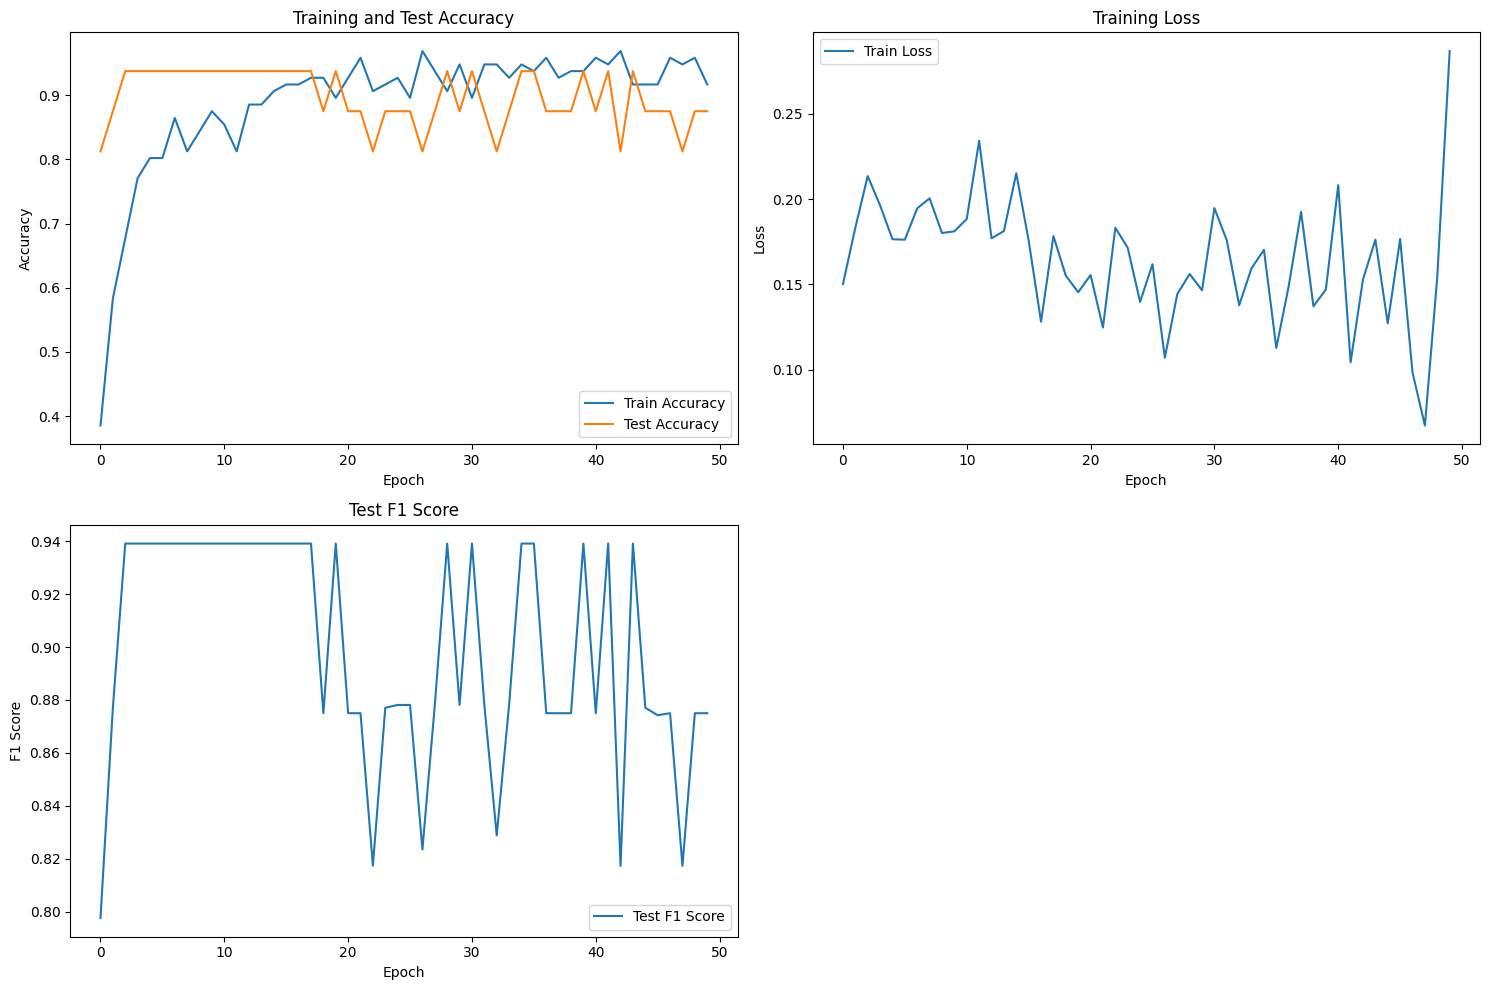

In [170]:
# Initialize and train
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
base_model = load_base_model()
rl_classifier = RLClassifier(base_model, device)


# Train the model and get metrics
train_accuracies, test_accuracies, train_losses, test_f1_scores = train_rl_classifier(
    rl_classifier, trainLoader, testLoader, num_epochs=50)

# Plot the training curves
plot_training_curves(train_accuracies, test_accuracies, train_losses, test_f1_scores)

In [226]:
plot_training_curves(train_accuracies, test_accuracies, train_losses, test_f1_scores)

In [227]:
from torchview import draw_graph
import torch

# Create a dummy input tensor (batch size 1, 3 channels, 224x224)
dummy_input = torch.randn(1, 3, 224, 224).to(device)

# Generate model architecture visualization
model_graph = draw_graph(rl_classifier.base_model, input_data=dummy_input, device=device, expand_nested=True)

# Save as an image
model_graph.visual_graph.render("../output/rl/mobilenetRL_architecture", format="jpg")
model_graph.visual_graph.render("../output/rl/mobilenetRL_architecture", format="svg")

'../output/rl/mobilenetRL_architecture.svg'

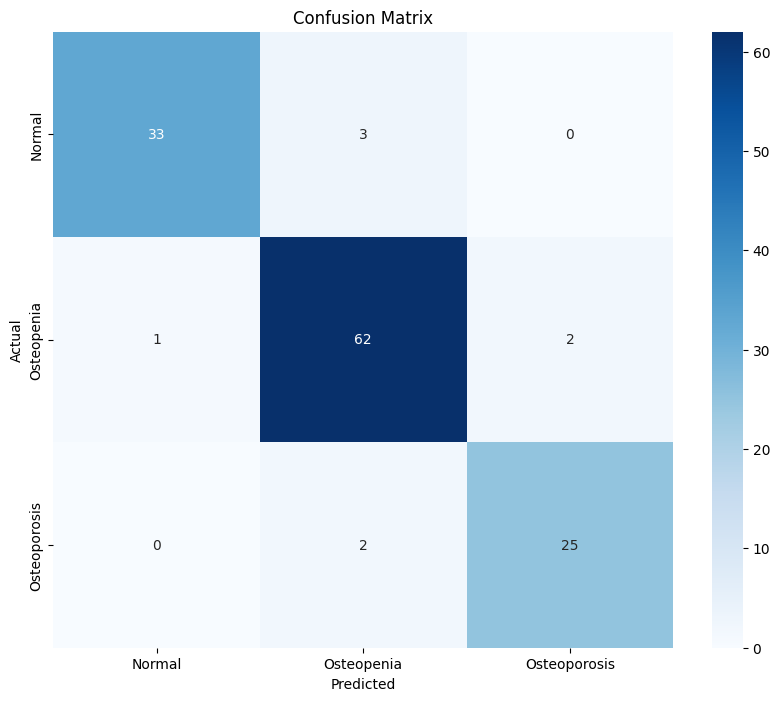


Classification Report:
              precision    recall  f1-score   support

      Normal       0.97      0.92      0.94        36
  Osteopenia       0.93      0.95      0.94        65
Osteoporosis       0.93      0.93      0.93        27

    accuracy                           0.94       128
   macro avg       0.94      0.93      0.94       128
weighted avg       0.94      0.94      0.94       128



In [228]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

def plot_confusion_matrix(model, test_loader, device):
    """
    Plot confusion matrix for the model predictions
    """
    model.base_model.eval()
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            predictions = model.predict(inputs)
            
            all_preds.extend(predictions.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    
    # Create confusion matrix
    cm = confusion_matrix(all_labels, all_preds)
    
    # Plot
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['Normal', 'Osteopenia', 'Osteoporosis'],
                yticklabels=['Normal', 'Osteopenia', 'Osteoporosis'])
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.savefig('../output/rl/confusion_matrix.jpg', bbox_inches='tight')
    plt.savefig('../output/rl/confusion_matrix.svg', bbox_inches='tight')
    plt.show()
    # Print classification report
    print("\nClassification Report:")
    print(classification_report(all_labels, all_preds, 
                              target_names=['Normal', 'Osteopenia', 'Osteoporosis']))

# Add this after training
plot_confusion_matrix(rl_classifier, evalLoader, device)

In [229]:
# Save the trained RL classifier
def save_rl_classifier(model, path="models/rl_classifier.pth"):
    # Create models directory if it doesn't exist
    os.makedirs(os.path.dirname(path), exist_ok=True)
    
    # Create state dict with all necessary components
    state_dict = {
        'base_model_state': model.base_model.state_dict(),
        'policy_net_state': model.policy_net.state_dict(),
        'target_net_state': model.target_net.state_dict(),
        'optimizer_state': model.optimizer.state_dict(),
        'device': str(model.device),
        'gamma': model.gamma,
        'batch_size': model.batch_size,
        'target_update': model.target_update,
        'memory_size': len(model.memory.memory)  # Access the memory size this way
    }
    
    torch.save(state_dict, path)
    print(f"Model saved to {path}")

# Save the model after training
save_rl_classifier(rl_classifier)

Model saved to models/rl_classifier.pth


3D Confusion Matrix:


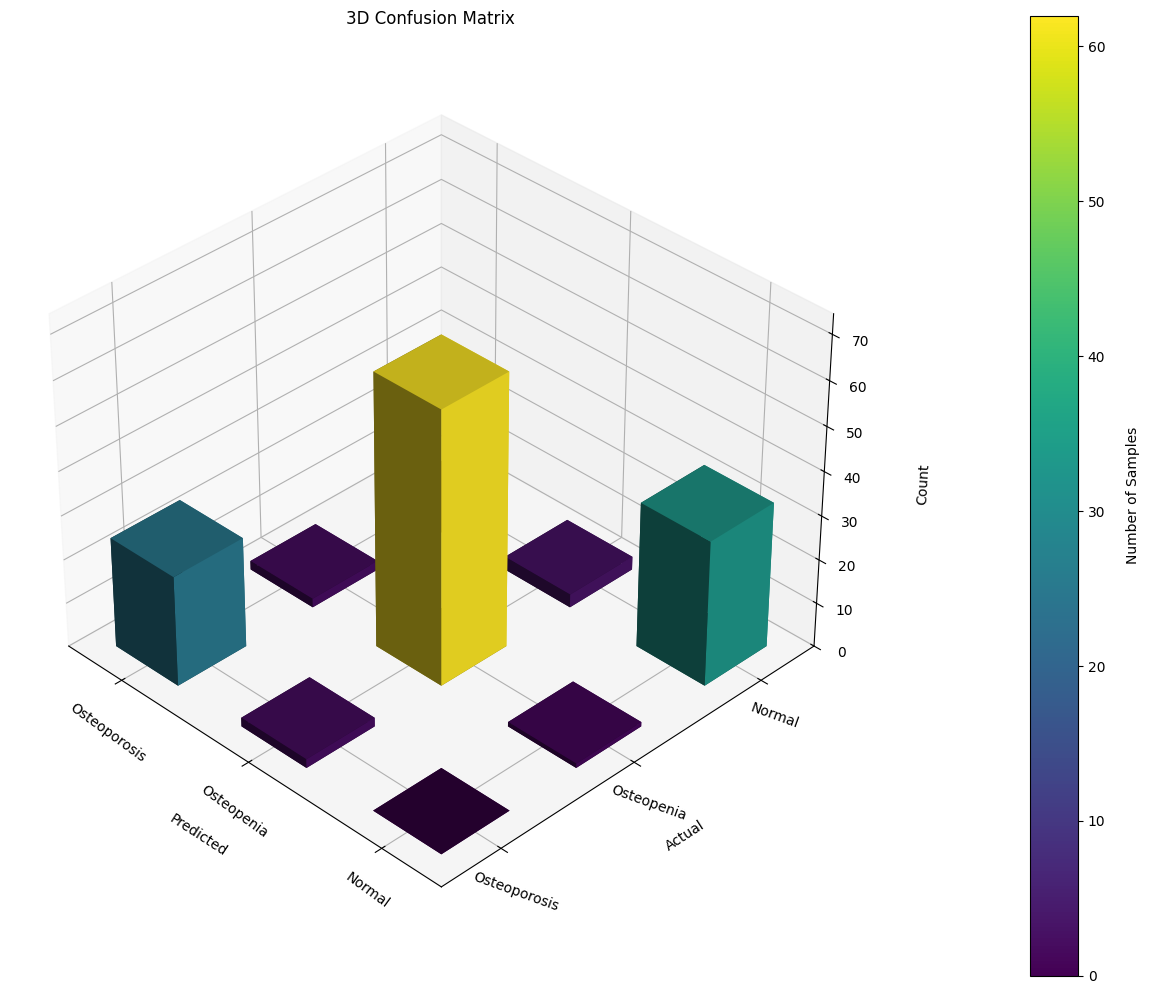


Feature Maps:


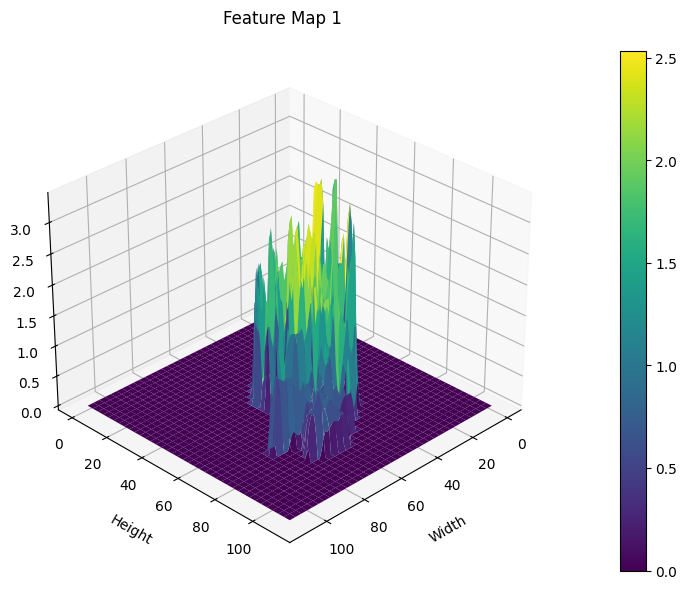

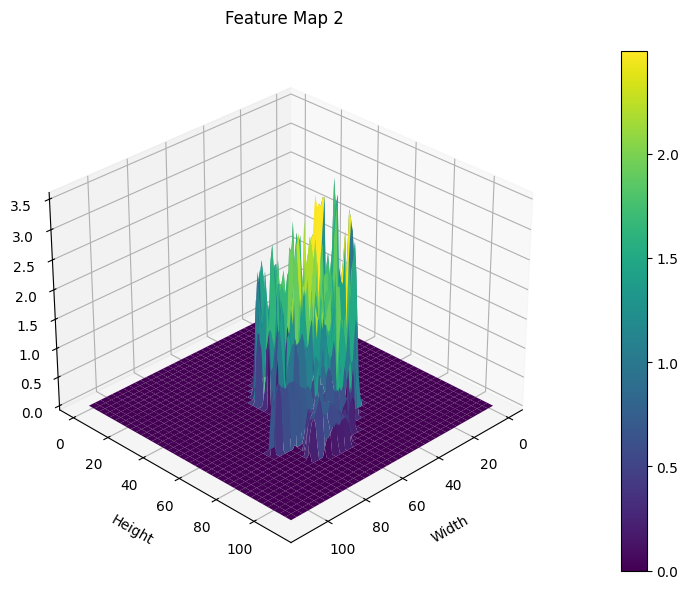

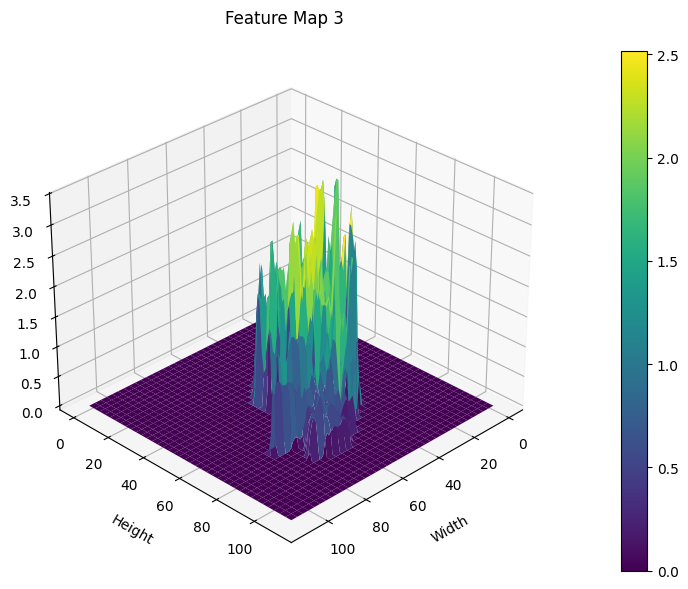

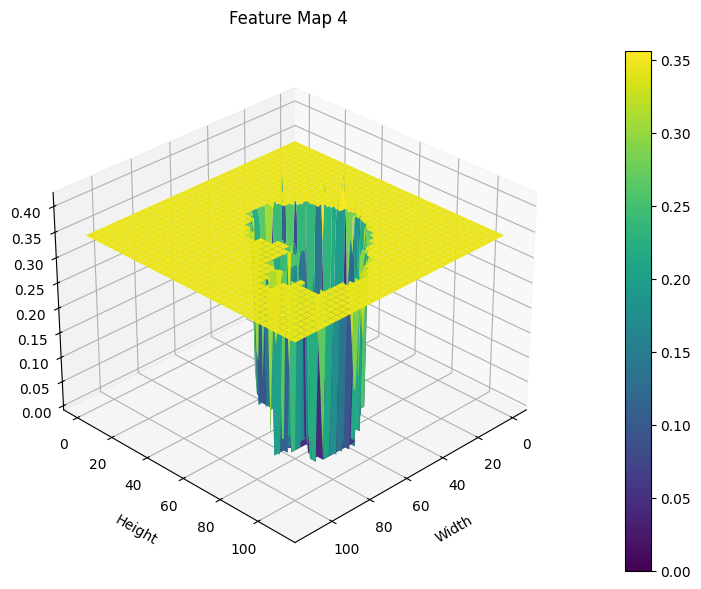

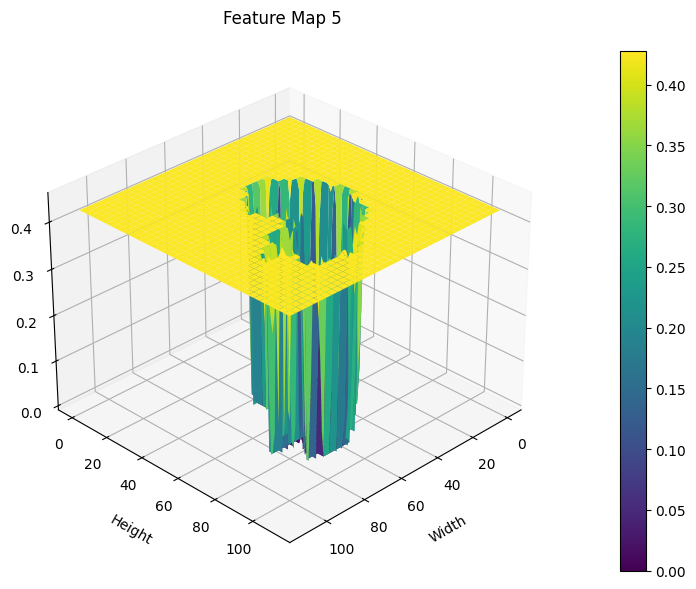

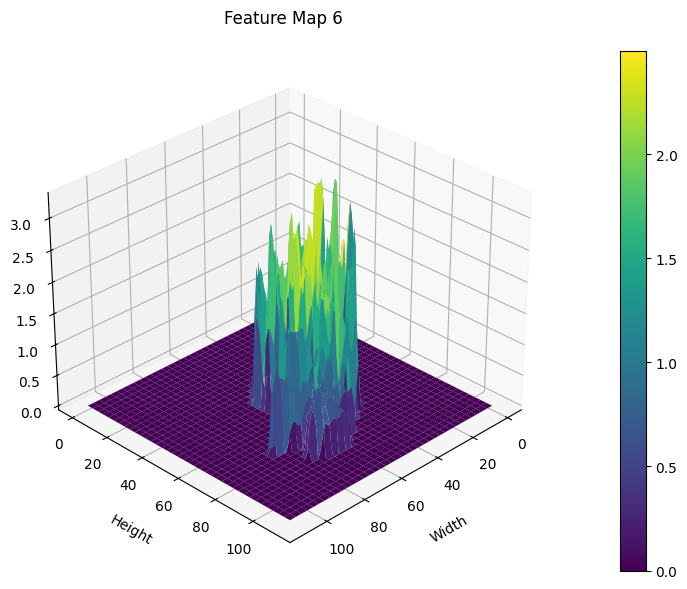

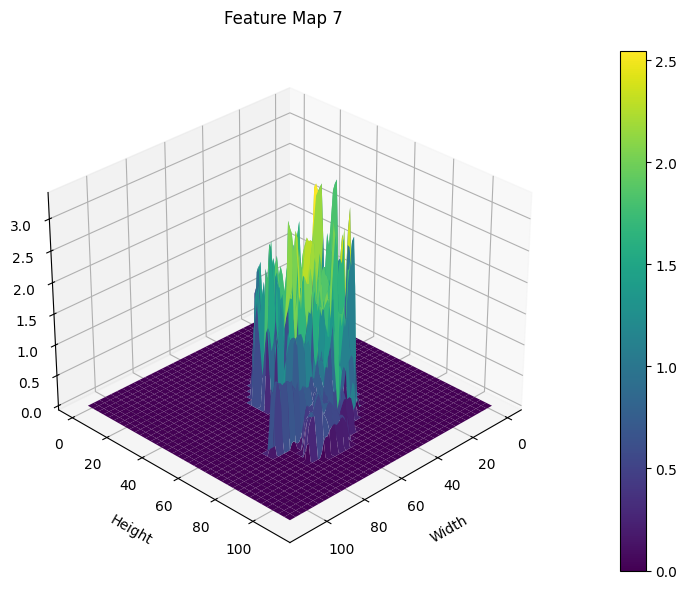

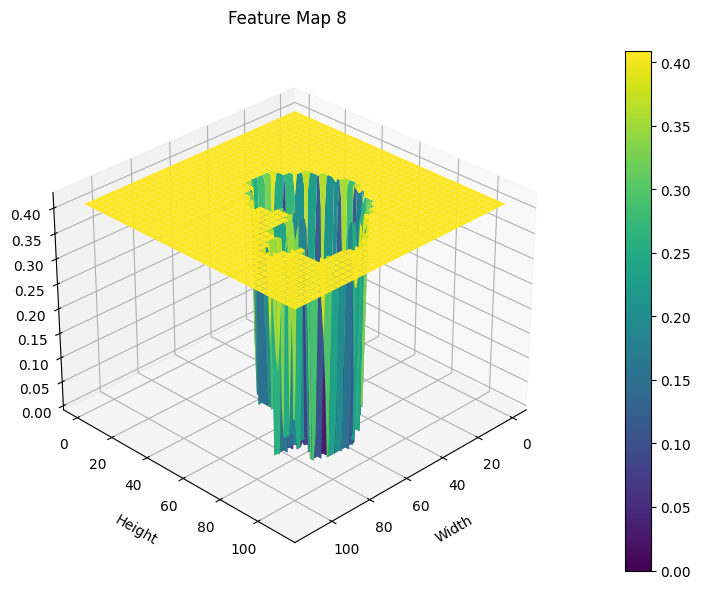


Classification Report Heatmap:


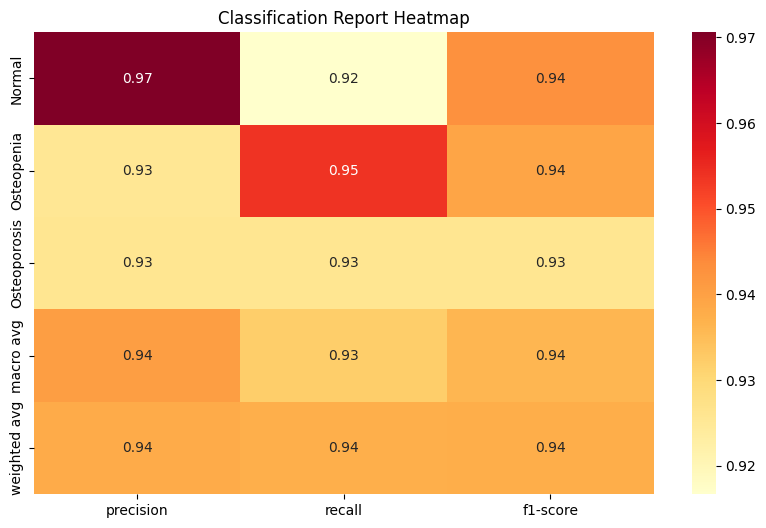

In [230]:

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
import seaborn as sns

def visualize_feature_maps(model, test_loader, device, num_features=8):
    """
    Visualize feature maps from an intermediate layer in individual plots
    """
    model.base_model.eval()
    
    # Get a batch of images
    images, _ = next(iter(test_loader))
    images = images.to(device)
    
    # Create a hook to get intermediate layer outputs
    activation = {}
    def get_activation(name):
        def hook(model, input, output):
            activation[name] = output.detach()
        return hook

    # Register hook on a convolutional layer
    model.base_model.features[0].register_forward_hook(get_activation('conv1'))
    
    # Forward pass
    with torch.no_grad():
        output = model.base_model(images)
    
    # Get feature maps
    feature_maps = activation['conv1']
    
    # Plot each feature map individually
    for i in range(min(num_features, feature_maps.size(1))):
        fig = plt.figure(figsize=(8, 6))
        ax = fig.add_subplot(111, projection='3d')
        
        # Get feature map
        feature_map = feature_maps[0, i].cpu().numpy()
        
        # Create mesh grid
        x, y = np.meshgrid(np.arange(feature_map.shape[0]), 
                          np.arange(feature_map.shape[1]))
        
        # Plot surface with enhanced visualization
        surf = ax.plot_surface(x, y, feature_map, cmap='viridis', 
                             edgecolor='none')
        
        # Customize the plot
        ax.set_title(f'Feature Map {i+1}', pad=20)
        ax.set_xlabel('Width', labelpad=10)
        ax.set_ylabel('Height', labelpad=10)
        ax.set_zlabel('Activation', labelpad=10)
        
        # Add colorbar
        plt.colorbar(surf, ax=ax, pad=0.1)
        
        # Adjust the viewing angle for better visibility
        ax.view_init(elev=30, azim=45)
        
        # Enable interactive rotation
        def on_move(event):
            if event.inaxes == ax:
                if event.button == 1:  # Left mouse button
                    ax.view_init(elev=event.ydata, azim=event.xdata)
                    plt.draw()
        
        fig.canvas.mpl_connect('motion_notify_event', on_move)
        
        plt.tight_layout()
        plt.savefig(f'../output/rl/feature_map_{i+1}.jpg', bbox_inches='tight')
        plt.savefig(f'../output/rl/feature_map_{i+1}.svg', bbox_inches='tight')
        plt.show()
        plt.close()  # Close the figure to free memory

def plot_3d_confusion_matrix(model, test_loader, device):
    """
    Plot 3D confusion matrix with improved rotation and visibility
    """
    model.base_model.eval()
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            predictions = model.predict(inputs)
            all_preds.extend(predictions.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    
    # Create confusion matrix
    cm = confusion_matrix(all_labels, all_preds)
    
    # Create 3D plot with larger figure size
    fig = plt.figure(figsize=(15, 12))
    ax = fig.add_subplot(111, projection='3d')
    
    # Create coordinates for the bars
    x_coords = np.arange(3)
    y_coords = np.arange(3)
    x_coords, y_coords = np.meshgrid(x_coords, y_coords)
    x_coords = x_coords.flatten()
    y_coords = y_coords.flatten()
    z_coords = np.zeros_like(x_coords)
    
    # Create the 3D bars with more spacing
    dx = dy = 0.5  # Reduced width for better spacing
    dz = cm.flatten()
    
    # Plot bars with custom colors
    colors = plt.cm.viridis(dz / float(max(dz)))
    bars = ax.bar3d(x_coords, y_coords, z_coords, dx, dy, dz, color=colors, shade=True)
    
    # Improve label visibility
    labels = ['Normal', 'Osteopenia', 'Osteoporosis']
    
    # Set axis labels with increased padding
    ax.set_xlabel('Predicted', labelpad=20)
    ax.set_ylabel('Actual', labelpad=20)
    ax.set_zlabel('Count', labelpad=20)
    
    # Set tick labels with better positioning
    ax.set_xticks(np.arange(3) + dx/2)
    ax.set_yticks(np.arange(3) + dy/2)
    
    # Rotate labels for better visibility
    ax.set_xticklabels(labels, rotation=-36)
    ax.set_yticklabels(labels, rotation=-20)
    
    # Adjust tick parameters
    ax.tick_params(axis='x', )
    ax.tick_params(axis='y', )
    
    # Set optimal viewing angle
    ax.view_init(elev=35, azim=135)  # Changed viewing angle
    
    # Adjust axis limits to give more space
    ax.set_zlim(0, np.max(dz) * 1.2)
    
    # Add grid for better depth perception
    ax.grid(True, linestyle='--', alpha=0.3)
    
    # Add title with increased padding
    plt.title('3D Confusion Matrix', pad=30, y=1.1)
    
    # Add colorbar with custom position and label
    norm = plt.Normalize(0, np.max(dz))
    sm = plt.cm.ScalarMappable(cmap=plt.cm.viridis, norm=norm)
    sm.set_array([])
    cbar = plt.colorbar(sm, ax=ax, pad=0.15)
    cbar.set_label('Number of Samples', labelpad=15)
    
    # Add margins to prevent label cutoff
    plt.subplots_adjust(left=0.1, right=0.9, bottom=0.1, top=0.9)
    
    # Enable mouse rotation
    def on_move(event):
        if event.inaxes == ax:
            if event.button == 1:  # Left mouse button
                ax.view_init(elev=event.ydata, azim=event.xdata)
                plt.draw()
    
    fig.canvas.mpl_connect('motion_notify_event', on_move)
    
    plt.savefig('../output/rl/3d_confusion_matrix.jpg', bbox_inches='tight')
    plt.savefig('../output/rl/3d_confusion_matrix.svg', bbox_inches='tight')
    plt.show()

def plot_classification_report_heatmap(model, test_loader, device):
    """
    Plot classification report as a heatmap
    """
    model.base_model.eval()
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            predictions = model.predict(inputs)
            
            all_preds.extend(predictions.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    
    # Get classification report as dict
    report = classification_report(all_labels, all_preds, 
                                 target_names=['Normal', 'Osteopenia', 'Osteoporosis'],
                                 output_dict=True)
    
    # Convert to DataFrame
    df = pd.DataFrame(report).T
    df = df.drop('support', axis=1)  # Remove support column
    df = df.drop('accuracy', axis=0)  # Remove accuracy row
    
    # Create heatmap
    plt.figure(figsize=(10, 6))
    sns.heatmap(df, annot=True, cmap='YlOrRd', fmt='.2f')
    plt.title('Classification Report Heatmap')
    plt.savefig('../output/rl/classification_report_heatmap.jpg', bbox_inches='tight')
    plt.savefig('../output/rl/classification_report_heatmap.svg', bbox_inches='tight')
    plt.show()

# Add these visualizations after training
print("3D Confusion Matrix:")
plot_3d_confusion_matrix(rl_classifier, evalLoader, device)

print("\nFeature Maps:")
visualize_feature_maps(rl_classifier, evalLoader, device)

print("\nClassification Report Heatmap:")
plot_classification_report_heatmap(rl_classifier, evalLoader, device)

In [231]:
import cv2

RL Metrics Visualization:


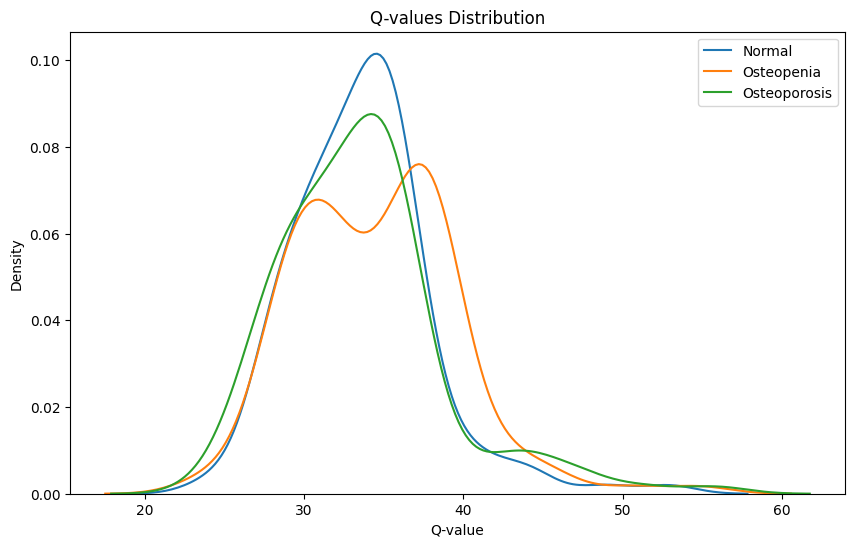

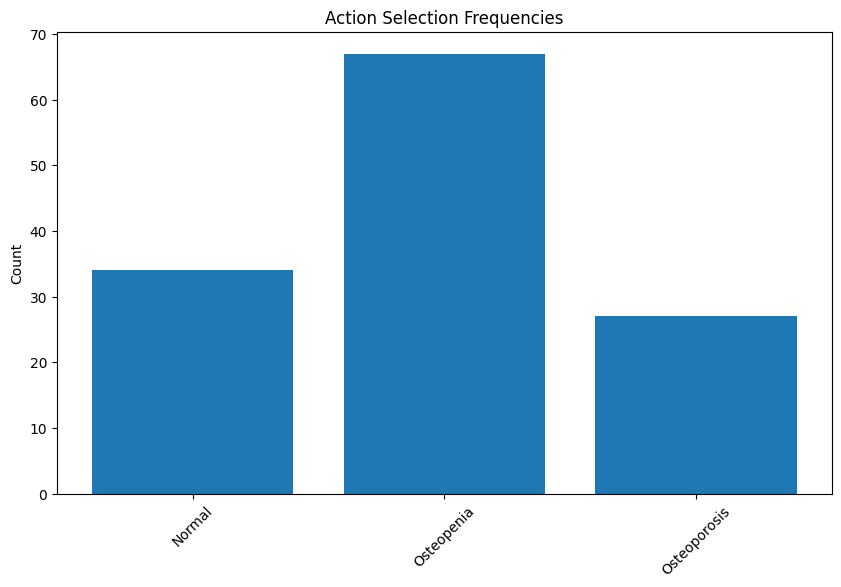

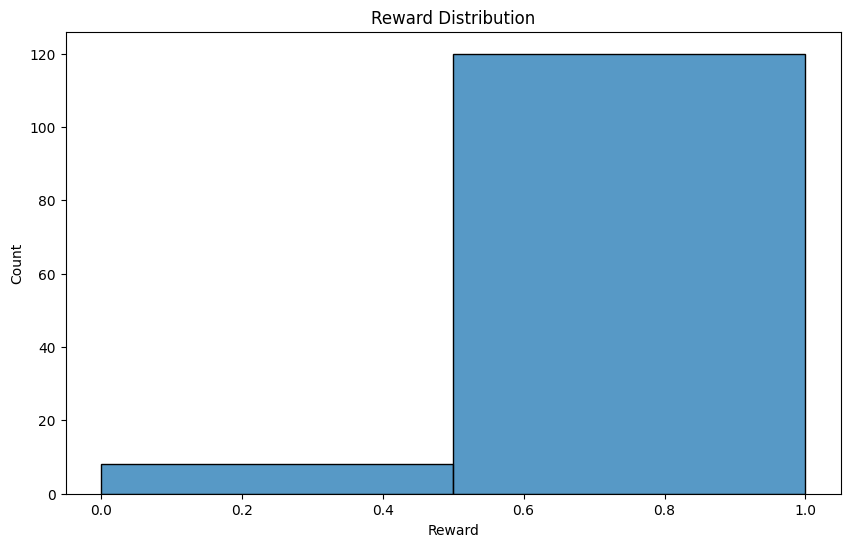

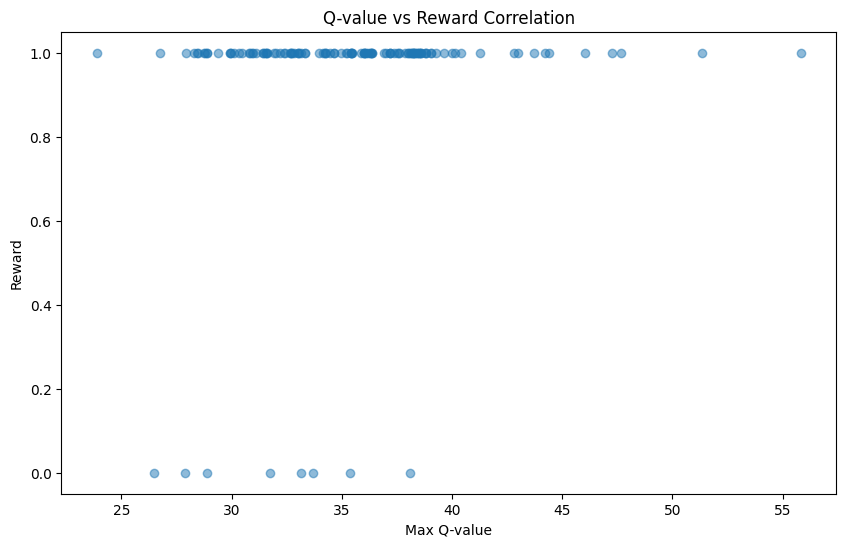


Policy Evolution Visualization:


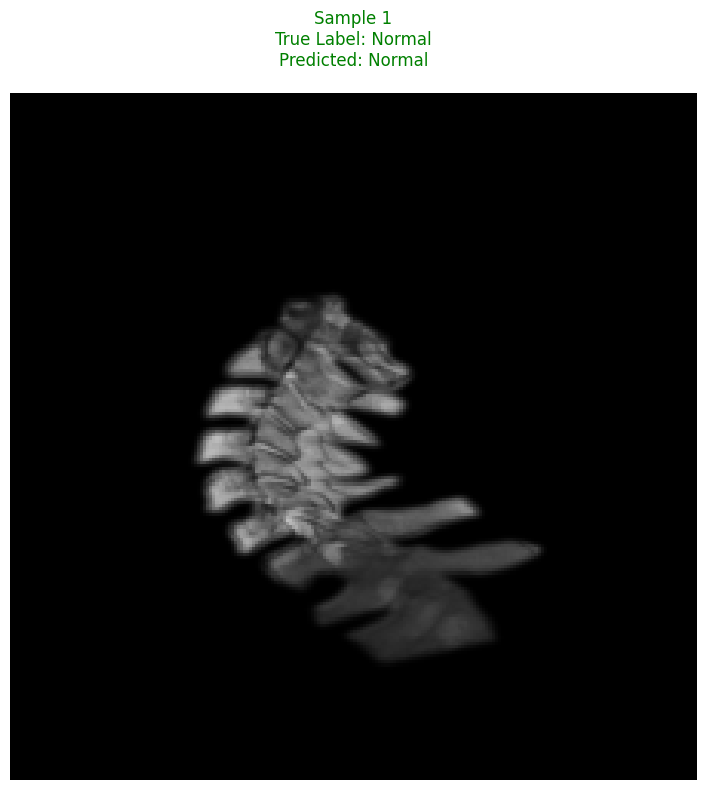

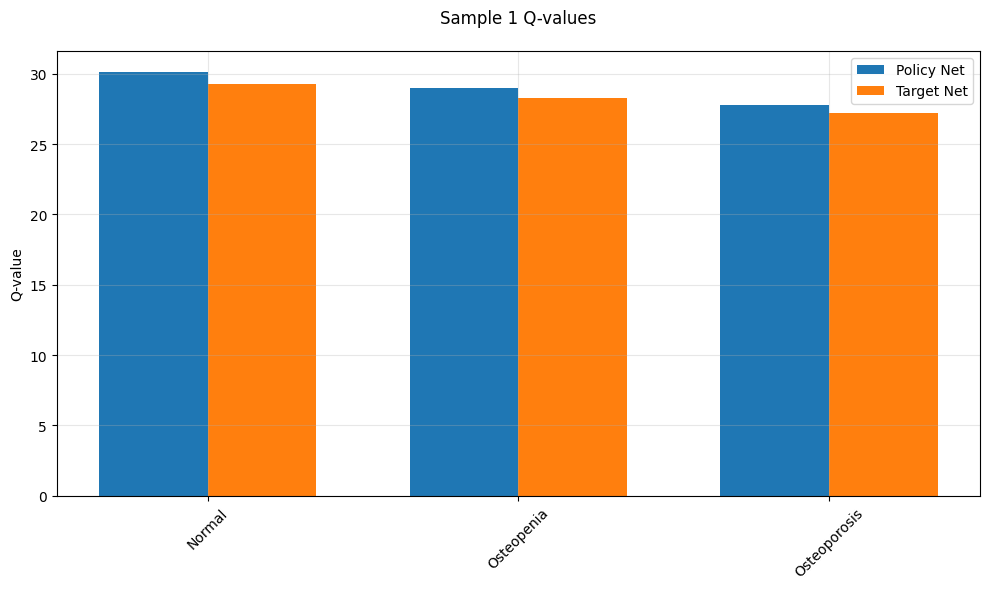

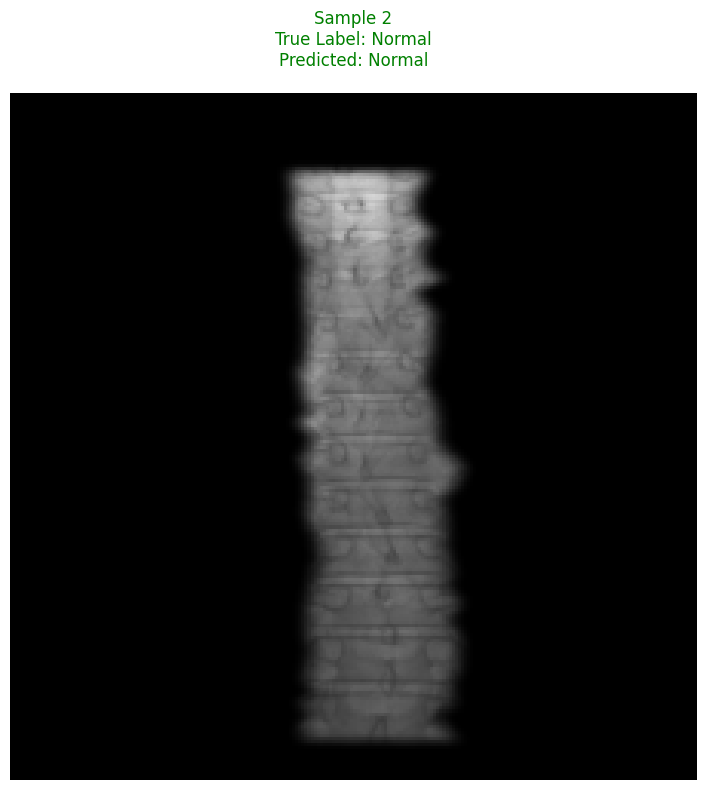

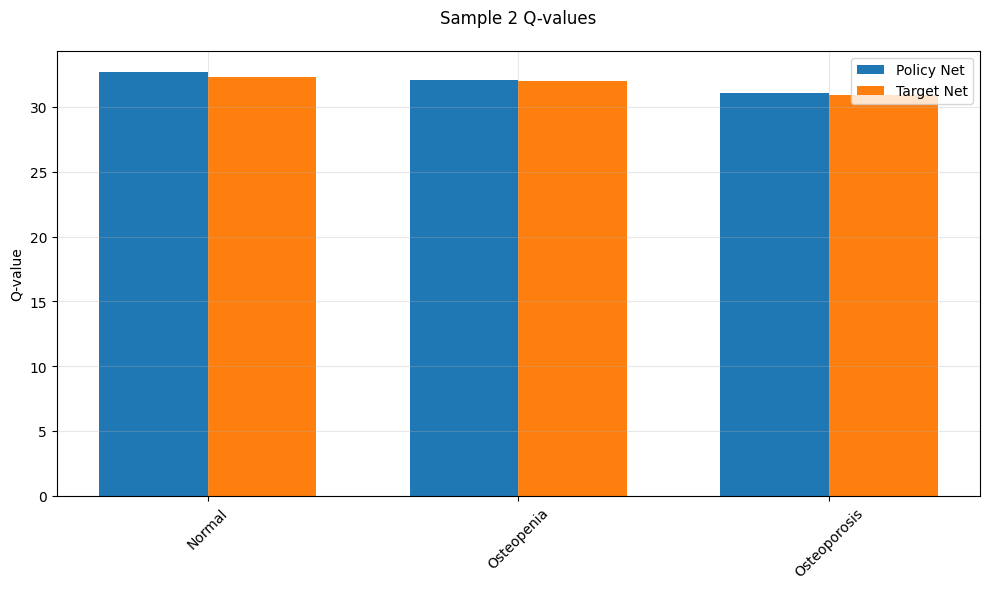

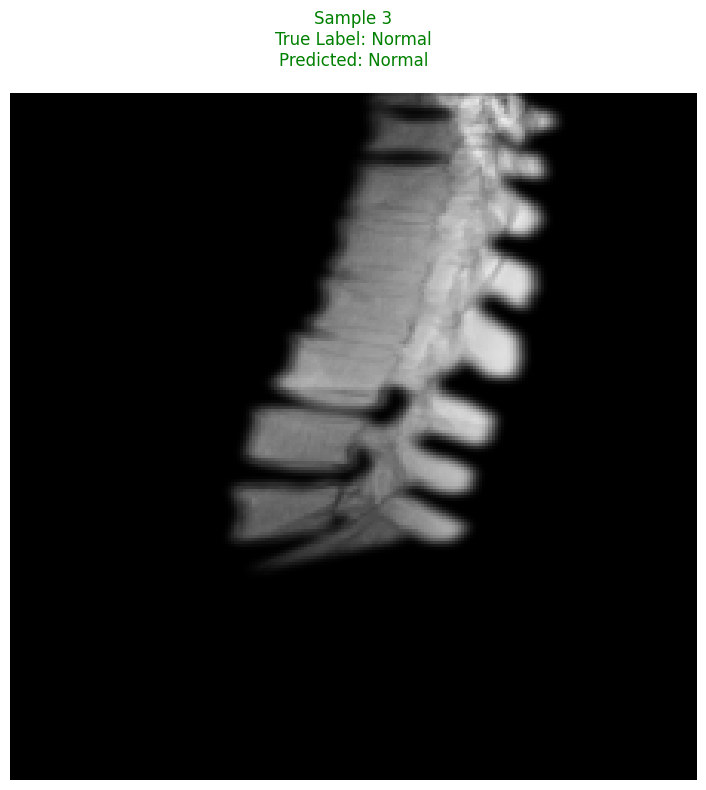

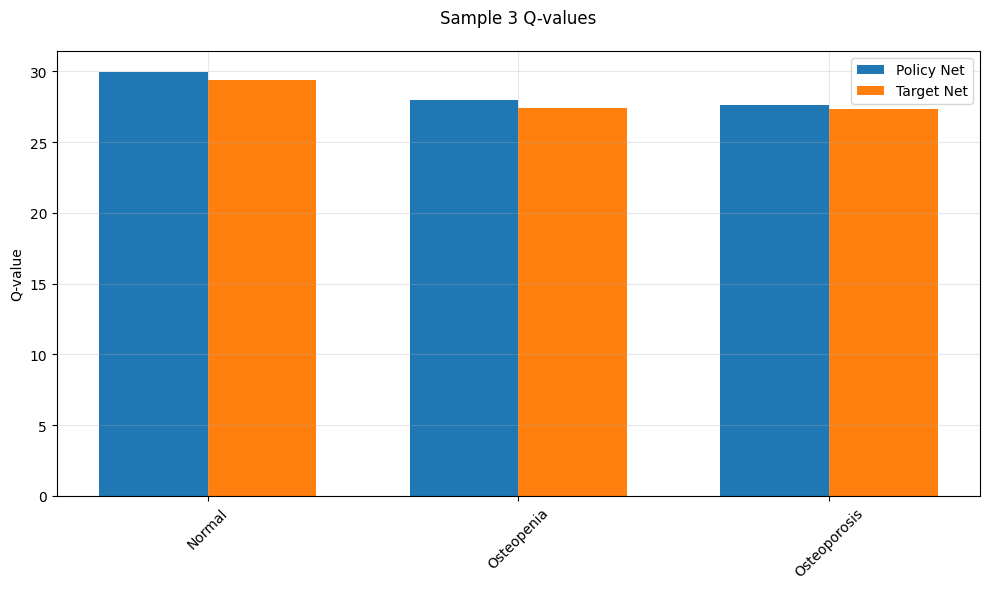

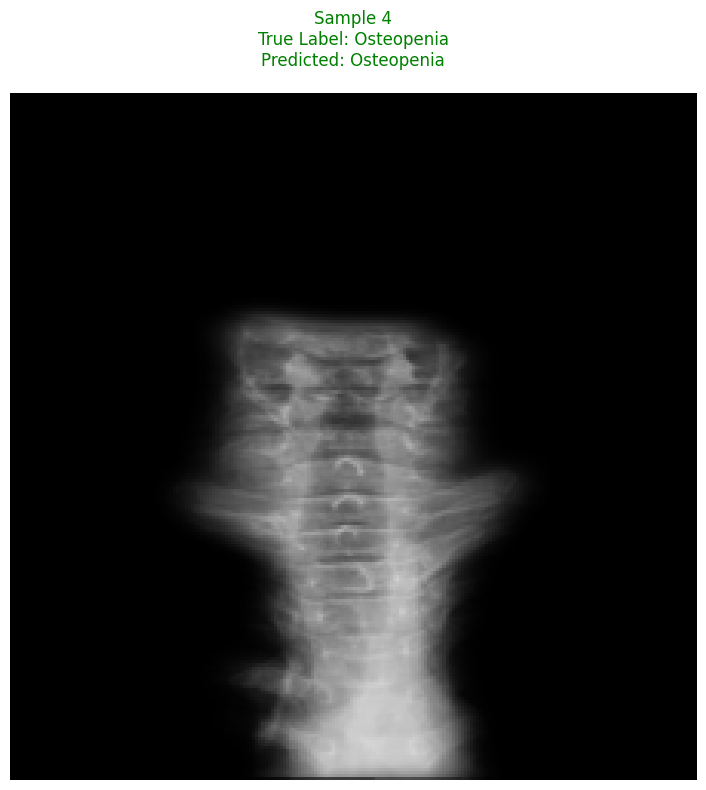

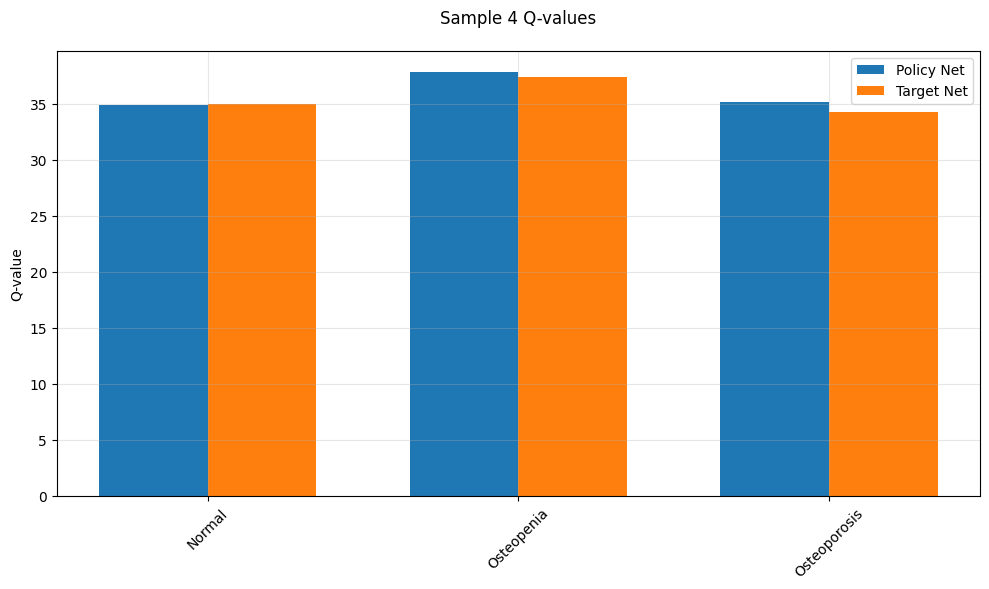

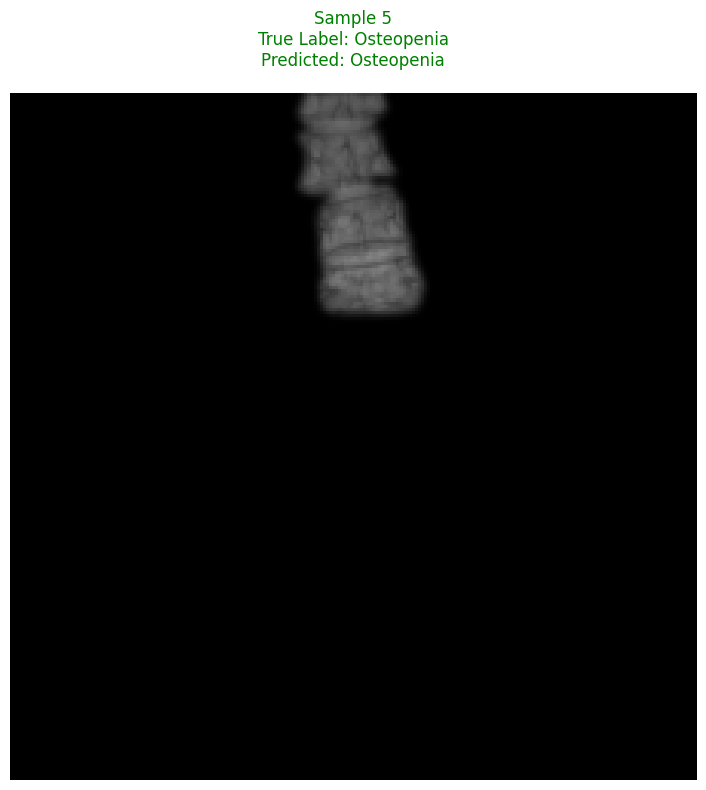

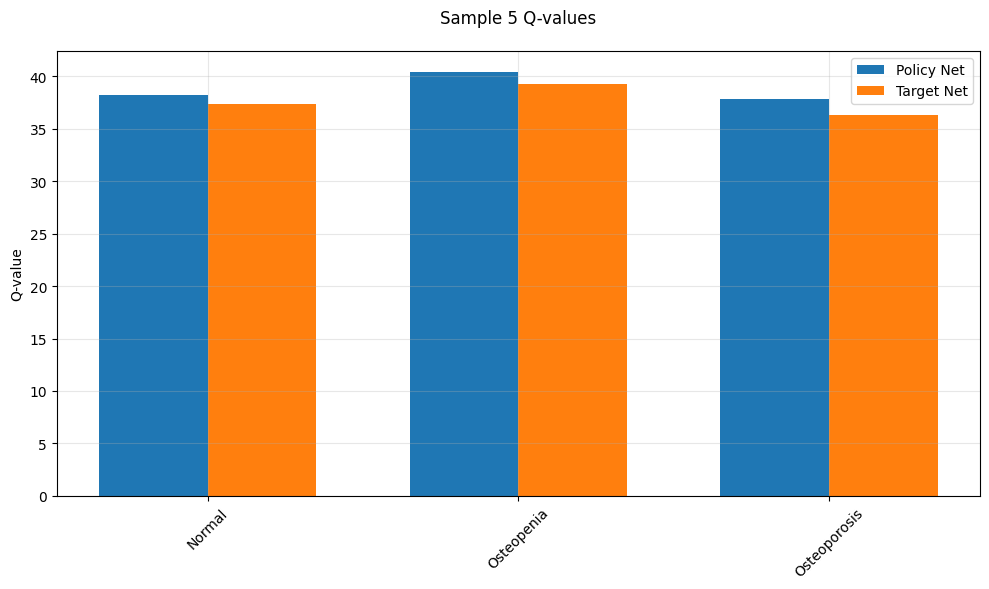

In [232]:
def visualize_rl_metrics(model, test_loader, device):
    """
    Visualize RL-specific metrics in separate plots
    """
    model.base_model.eval()
    q_values_list = []
    actions_list = []
    rewards_list = []
    
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            
            # Get features from base model
            features = model.base_model.features(inputs)
            features = F.adaptive_avg_pool2d(features, (1, 1))
            features = features.view(features.size(0), -1)
            
            # Get Q-values from policy network
            q_values = model.policy_net(features)
            
            # Calculate rewards based on predictions
            predictions = model.predict(inputs)
            rewards = (predictions == labels).float()
            
            q_values_list.extend(q_values.cpu().numpy())
            actions_list.extend(predictions.cpu().numpy())
            rewards_list.extend(rewards.cpu().numpy())
    
    # Convert to numpy arrays
    q_values_array = np.array(q_values_list)
    
    # 1. Q-values Distribution
    plt.figure(figsize=(10, 6))
    for i in range(q_values_array.shape[1]):
        sns.kdeplot(q_values_array[:, i], label=f'Action {i}')
    plt.title('Q-values Distribution')
    plt.xlabel('Q-value')
    plt.ylabel('Density')
    plt.legend(['Normal', 'Osteopenia', 'Osteoporosis'])
    plt.savefig('../output/rl/q_values_distribution.jpg', bbox_inches='tight')
    plt.savefig('../output/rl/q_values_distribution.svg', bbox_inches='tight')
    plt.show()
    # 2. Action Selection Frequencies
    plt.figure(figsize=(10, 6))
    action_counts = np.bincount(actions_list)
    action_labels = ['Normal', 'Osteopenia', 'Osteoporosis']
    plt.bar(action_labels, action_counts)
    plt.title('Action Selection Frequencies')
    plt.ylabel('Count')
    plt.xticks(rotation=45)
    plt.savefig('../output/rl/action_selection_frequencies.jpg', bbox_inches='tight')
    plt.savefig('../output/rl/action_selection_frequencies.svg', bbox_inches='tight')
    plt.show()
    # 3. Reward Distribution
    plt.figure(figsize=(10, 6))
    sns.histplot(rewards_list, bins=2)
    plt.title('Reward Distribution')
    plt.xlabel('Reward')
    plt.ylabel('Count')
    plt.savefig('../output/rl/reward_distribution.jpg', bbox_inches='tight')
    plt.savefig('../output/rl/reward_distribution.svg', bbox_inches='tight')
    plt.show()
    # 4. Q-value vs Reward Correlation
    plt.figure(figsize=(10, 6))
    max_q_values = np.max(q_values_array, axis=1)
    plt.scatter(max_q_values, rewards_list, alpha=0.5)
    plt.title('Q-value vs Reward Correlation')
    plt.xlabel('Max Q-value')
    plt.ylabel('Reward')
    plt.savefig('../output/rl/q_value_vs_reward_correlation.jpg', bbox_inches='tight')  
    plt.savefig('../output/rl/q_value_vs_reward_correlation.svg', bbox_inches='tight')
    plt.show()
def plot_3d_confusion_matrix(model, test_loader, device):
    """
    Plot 3D confusion matrix with improved label visibility
    """
    model.base_model.eval()
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            predictions = model.predict(inputs)
            all_preds.extend(predictions.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    
    # Create confusion matrix
    cm = confusion_matrix(all_labels, all_preds)
    
    # Create 3D plot
    fig = plt.figure(figsize=(12, 8))
    ax = fig.add_subplot(111, projection='3d')
    
    # Create coordinates for the bars
    x_coords = np.arange(3)
    y_coords = np.arange(3)
    x_coords, y_coords = np.meshgrid(x_coords, y_coords)
    x_coords = x_coords.flatten()
    y_coords = y_coords.flatten()
    z_coords = np.zeros_like(x_coords)
    
    # Create the 3D bars
    dx = dy = 0.75
    dz = cm.flatten()
    
    # Plot bars with custom colors
    colors = plt.cm.viridis(dz / float(max(dz)))
    bars = ax.bar3d(x_coords, y_coords, z_coords, dx, dy, dz, color=colors)
    
    # Improve label visibility
    labels = ['Normal', 'Osteopenia', 'Osteoporosis']
    
    # Set axis labels with better positioning
    ax.set_xlabel('Predicted', labelpad=10)
    ax.set_ylabel('Actual', labelpad=10)
    ax.set_zlabel('Count', labelpad=10)
    
    # Set tick labels with better positioning
    ax.set_xticks(np.arange(3) + dx/2)
    ax.set_yticks(np.arange(3) + dy/2)
    ax.set_xticklabels(labels, rotation=15, ha='right')
    ax.set_yticklabels(labels, rotation=-15, ha='right')
    
    # Adjust viewing angle for better label visibility
    ax.view_init(elev=20, azim=45)
    
    # Add title
    plt.title('3D Confusion Matrix', pad=20)
    
    # Add colorbar
    norm = plt.Normalize(0, np.max(dz))
    sm = plt.cm.ScalarMappable(cmap=plt.cm.viridis, norm=norm)
    sm.set_array([])
    plt.colorbar(sm)
    
    plt.tight_layout()
    plt.savefig('../output/rl/3d_confusion_matrix.jpg', bbox_inches='tight')
    plt.savefig('../output/rl/3d_confusion_matrix.svg', bbox_inches='tight')
    plt.show()

def get_gradcam(model, input_tensor, target_layer):
    """
    Generate Grad-CAM heatmap with proper gradient handling
    """
    # Get the feature maps from target layer
    activation = {}
    gradients = {}
    
    def get_activation(name):
        def hook(model, input, output):
            activation[name] = output
        return hook
    
    def get_gradient(name):
        def hook(grad):
            gradients[name] = grad
        return hook
    
    # Register hooks
    handle1 = target_layer.register_forward_hook(get_activation('target'))
    
    # Forward pass
    model.zero_grad()
    output = model(input_tensor)
    pred_class = output.argmax(dim=1)
    
    # Get activations and register backward hook
    act = activation['target']
    handle2 = act.register_hook(get_gradient('target'))
    
    # Create one-hot encoded tensor for the predicted class
    one_hot = torch.zeros_like(output)
    one_hot[0][pred_class] = 1
    
    # Backward pass with the one-hot encoded tensor
    output.backward(gradient=one_hot)
    
    # Get gradients and activations
    gradients = gradients['target']
    activations = activation['target']
    
    # Remove hooks
    handle1.remove()
    handle2.remove()
    
    # Calculate weights
    weights = torch.mean(gradients, dim=(2, 3))[0]
    
    # Generate heatmap
    heatmap = torch.sum(weights[:, None, None] * activations[0], dim=0)
    heatmap = F.relu(heatmap)  # ReLU to only keep positive contributions
    heatmap = heatmap.detach().cpu().numpy()
    
    # Normalize heatmap
    heatmap = (heatmap - heatmap.min()) / (heatmap.max() - heatmap.min() + 1e-8)
    
    return heatmap

def visualize_policy_evolution(model, test_loader, device, num_samples=5):
    """
    Visualize policy evolution with image and Q-values in separate plots
    """
    model.base_model.eval()
    label_map = {0: 'Normal', 1: 'Osteopenia', 2: 'Osteoporosis'}
    
    for i, (inputs, labels) in enumerate(test_loader):
        if i >= num_samples:
            break
            
        inputs, labels = inputs.to(device), labels.to(device)
        
        # Get predictions
        predictions = model.predict(inputs)
        
        # Create two separate figures
        # Figure 1: Original Image
        plt.figure(figsize=(8, 8))
        img = inputs[0].cpu().permute(1, 2, 0)
        plt.imshow(img)
        
        # Get true and predicted labels
        true_label = label_map[labels[0].item()]
        pred_label = label_map[predictions[0].item()]
        
        # Color code the prediction
        pred_color = 'green' if true_label == pred_label else 'red'
        plt.title(f'Sample {i+1}\nTrue Label: {true_label}\nPredicted: {pred_label}', 
                 color=pred_color, pad=20)
        plt.axis('off')
        plt.tight_layout()
        plt.savefig(f'../output/rl/classified_image_{i+1}.jpg', bbox_inches='tight')
        plt.savefig(f'../output/rl/classified_image_{i+1}.svg', bbox_inches='tight')
        plt.show()
        plt.close()
        
        # Figure 2: Q-values
        plt.figure(figsize=(10, 6))
        features = model.base_model.features(inputs)
        features = F.adaptive_avg_pool2d(features, (1, 1))
        features = features.view(features.size(0), -1)
        
        policy_q_values = model.policy_net(features)
        target_q_values = model.target_net(features)
        
        x = np.arange(3)
        width = 0.35
        
        # Detach tensors before converting to numpy
        policy_values = policy_q_values[0].detach().cpu().numpy()
        target_values = target_q_values[0].detach().cpu().numpy()
        
        plt.bar(x - width/2, policy_values, width, label='Policy Net')
        plt.bar(x + width/2, target_values, width, label='Target Net')
        plt.xticks(x, ['Normal', 'Osteopenia', 'Osteoporosis'], rotation=45)
        plt.title(f'Sample {i+1} Q-values', pad=20)
        plt.legend()
        plt.grid(True, alpha=0.3)
        plt.ylabel('Q-value')
        plt.tight_layout()
        plt.savefig(f'../output/rl/policy_evolution_{i+1}.jpg', bbox_inches='tight')
        plt.savefig(f'../output/rl/policy_evolution_{i+1}.svg', bbox_inches='tight')
        plt.show()
        plt.close()



print("RL Metrics Visualization:")
visualize_rl_metrics(rl_classifier, evalLoader, device)


print("\nPolicy Evolution Visualization:")
visualize_policy_evolution(rl_classifier, evalLoader, device)


RL Training Metrics:


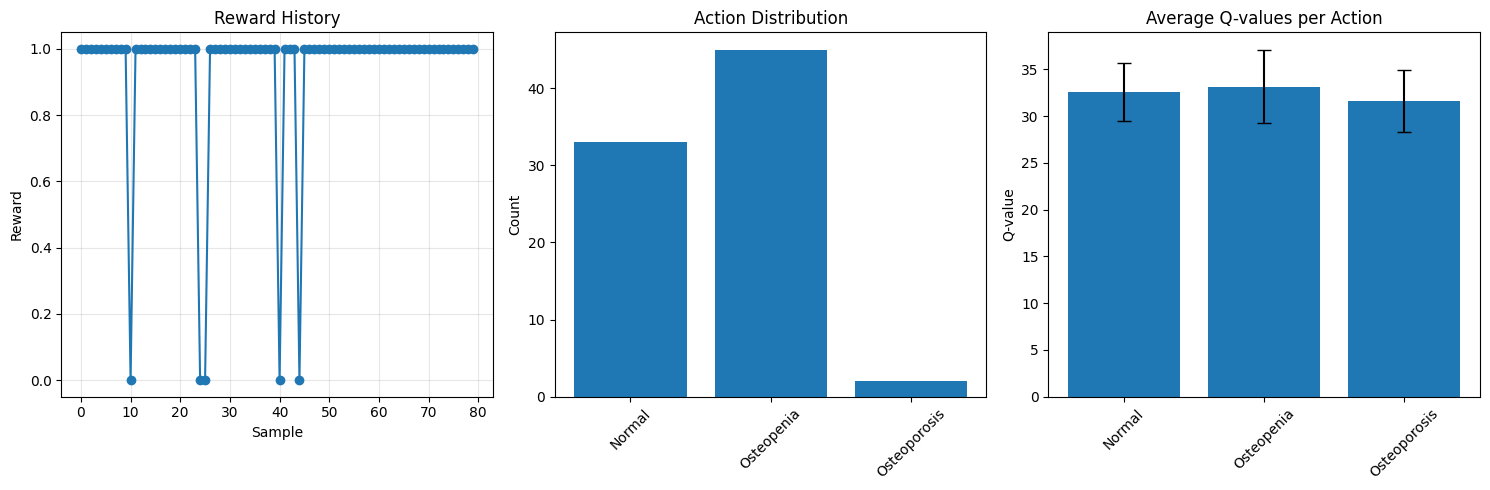


RL Training Summary:
Average Reward: 0.938
Accuracy: 0.938

Action Distribution:
Normal: 33 (41.2%)
Osteopenia: 45 (56.2%)
Osteoporosis: 2 (2.5%)

Average Q-values:
Normal: 32.581 ± 3.105
Osteopenia: 33.172 ± 3.947
Osteoporosis: 31.602 ± 3.321


In [233]:
def visualize_rl_training_metrics(model, test_loader, device, num_samples=5):
    """
    Visualize RL-specific training metrics
    """
    model.base_model.eval()
    label_map = {0: 'Normal', 1: 'Osteopenia', 2: 'Osteoporosis'}
    
    # Collect data for visualization
    rewards = []
    actions = []
    q_values_history = []
    correct_predictions = 0
    
    with torch.no_grad():
        for i, (inputs, labels) in enumerate(test_loader):
            if i >= num_samples:
                break
                
            inputs, labels = inputs.to(device), labels.to(device)
            
            # Get features and Q-values
            features = model.base_model.features(inputs)
            features = F.adaptive_avg_pool2d(features, (1, 1))
            features = features.view(features.size(0), -1)
            
            q_values = model.policy_net(features)
            actions.append(q_values.argmax(dim=1).cpu().numpy())
            q_values_history.append(q_values.cpu().numpy())
            
            # Calculate rewards
            predictions = model.predict(inputs)
            batch_rewards = (predictions == labels).float()
            rewards.extend(batch_rewards.cpu().numpy())
            correct_predictions += (predictions == labels).sum().item()
    
    # Plot 1: Reward History
    plt.figure(figsize=(15, 5))
    plt.subplot(1, 3, 1)
    plt.plot(rewards, marker='o')
    plt.title('Reward History')
    plt.xlabel('Sample')
    plt.ylabel('Reward')
    plt.grid(True, alpha=0.3)
    
    # Plot 2: Action Distribution
    plt.subplot(1, 3, 2)
    action_counts = np.bincount(np.concatenate(actions), minlength=3)
    plt.bar(['Normal', 'Osteopenia', 'Osteoporosis'], action_counts)
    plt.title('Action Distribution')
    plt.ylabel('Count')
    plt.xticks(rotation=45)
    
    # Plot 3: Average Q-values per Action
    plt.subplot(1, 3, 3)
    q_values_array = np.concatenate(q_values_history)
    avg_q_values = q_values_array.mean(axis=0)
    std_q_values = q_values_array.std(axis=0)
    
    x = np.arange(3)
    plt.bar(x, avg_q_values, yerr=std_q_values, capsize=5)
    plt.title('Average Q-values per Action')
    plt.xticks(x, ['Normal', 'Osteopenia', 'Osteoporosis'], rotation=45)
    plt.ylabel('Q-value')
    
    plt.tight_layout()
    plt.savefig('../output/rl/rl_training_metrics.jpg', bbox_inches='tight')
    plt.savefig('../output/rl/rl_training_metrics.svg', bbox_inches='tight')
    plt.show()
    
    # Print summary statistics
    print("\nRL Training Summary:")
    print(f"Average Reward: {np.mean(rewards):.3f}")
    print(f"Accuracy: {correct_predictions/(len(rewards)):.3f}")
    print("\nAction Distribution:")
    for i, count in enumerate(action_counts):
        print(f"{label_map[i]}: {count} ({count/len(rewards)*100:.1f}%)")
    print("\nAverage Q-values:")
    for i, q_val in enumerate(avg_q_values):
        print(f"{label_map[i]}: {q_val:.3f} ± {std_q_values[i]:.3f}")

# Add visualization
print("\nRL Training Metrics:")
visualize_rl_training_metrics(rl_classifier, evalLoader, device)